# ECE 57000 Assignment 5 Exercise

Your Name: Roshan Sundar

Prepare the pacakge we will use.

In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [2]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [3]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
simple_model = simple_model.to(device)
rand_tensor = rand_tensor.to(device)
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.)

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-12 times per epoch. The print statement should be:
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is:
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement
* The `train` function should return a list named `train_loss`, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary named `test_stat` with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the testset, average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [21]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    model.train()
    train_loss = []

    for batch_idx, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      if batch_idx % (len(train_loader) // 10) == 0:
        print(f'Epoch {epoch}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    model.eval()

    test_loss = 0
    correct = 0
    predictions = []

    with torch.no_grad():
      for images, labels in test_loader:
        output = model(images)
        test_loss += loss_fn(output, labels).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item()
        predictions.extend(pred.cpu().numpy())

    avg_loss = test_loss / len(test_loader.dataset)
    avg_accuracy = correct / len(test_loader.dataset)

    test_stat = {
        "loss": avg_loss,
        "accuracy": avg_accuracy,
        "prediction": torch.tensor(predictions)
    }
    print(f"Test result on epoch {epoch}: total sample: {len(test_loader.dataset)}, Avg loss: {avg_loss:.3f}, Acc: {100 * avg_accuracy:.3f}%")

    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions.
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [6]:
# Download MNIST and transformation
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
# ----------- <End Your code> ---------------

100%|██████████| 9912422/9912422 [00:00<00:00, 125378726.98it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115038645.61it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64254974.33it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4928985.45it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [45]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------
class OurFC(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(OurFC, self).__init__()

        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        self.fc_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

class OurCNN(nn.Module):
    def __init__(self, num_conv_layers, num_channels, num_fc_layers, num_classes):
        super(OurCNN, self).__init__()

        conv_layers = []
        in_channels = 1
        for _ in range(num_conv_layers):
            conv_layers.extend([
                nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = num_channels

        self.conv_layers = nn.Sequential(*conv_layers)

        fc_layers = []
        fc_input_size = num_channels * 7 * 7
        for _ in range(num_fc_layers):
            fc_layers.extend([
                nn.Linear(fc_input_size, num_channels),
                nn.ReLU(),
                nn.Dropout(0.5)
            ])
            fc_input_size = num_channels

        fc_layers.append(nn.Linear(fc_input_size, num_classes))

        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x
# ----------- <End Your code> ---------------

In [29]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------
classifier = OurFC(28*28, [200, 64], 10)
optimizer = optim.SGD(classifier.parameters(), lr=0.1, momentum=0.8)
train(classifier, criterion, optimizer, train_loader, max_epoch)
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 3: [0/60000] Loss: 2.299
Epoch 3: [5952/60000] Loss: 0.431
Epoch 3: [11904/60000] Loss: 0.272
Epoch 3: [17856/60000] Loss: 0.177
Epoch 3: [23808/60000] Loss: 0.134
Epoch 3: [29760/60000] Loss: 0.149
Epoch 3: [35712/60000] Loss: 0.379
Epoch 3: [41664/60000] Loss: 0.217
Epoch 3: [47616/60000] Loss: 0.088
Epoch 3: [53568/60000] Loss: 0.044
Epoch 3: [59520/60000] Loss: 0.140
Finished Training after 13.924424886703491 s 


In [30]:
# Test FC Model
test(classifier, criterion, train_loader, max_epoch)

Test result on epoch 3: total sample: 60000, Avg loss: 0.002, Acc: 96.355%


{'loss': 0.0018034490663247805,
 'accuracy': 0.96355,
 'prediction': tensor([[8],
         [0],
         [0],
         ...,
         [9],
         [8],
         [1]])}

In [47]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
classifier = OurCNN(2,32,2,10)
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)
train(classifier, criterion, optimizer, train_loader, max_epoch)
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 3: [0/60000] Loss: 2.335
Epoch 3: [5952/60000] Loss: 2.013
Epoch 3: [11904/60000] Loss: 1.349
Epoch 3: [17856/60000] Loss: 1.210
Epoch 3: [23808/60000] Loss: 1.340
Epoch 3: [29760/60000] Loss: 0.813
Epoch 3: [35712/60000] Loss: 0.813
Epoch 3: [41664/60000] Loss: 0.613
Epoch 3: [47616/60000] Loss: 0.629
Epoch 3: [53568/60000] Loss: 0.598
Epoch 3: [59520/60000] Loss: 0.696
Finished Training after 44.07989978790283 s 


In [48]:
# Test CNN Model
test(classifier, criterion, train_loader, max_epoch)

Test result on epoch 3: total sample: 60000, Avg loss: 0.003, Acc: 95.163%


{'loss': 0.003290765647403896,
 'accuracy': 0.9516333333333333,
 'prediction': tensor([[1],
         [6],
         [4],
         ...,
         [3],
         [8],
         [1]])}

In [ ]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


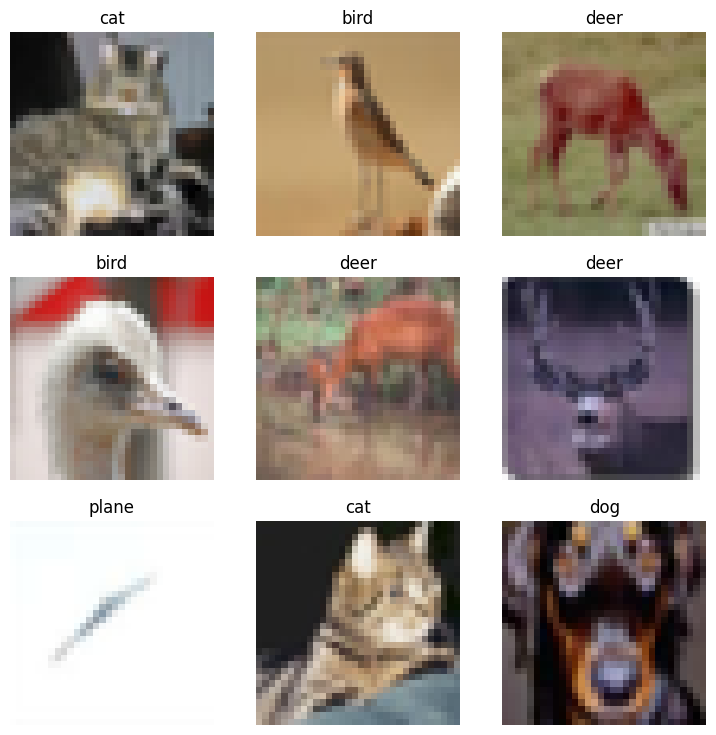

In [61]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
train_loader = torch.utils.data.DataLoader(trainset, batch_size=9, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=9, shuffle=False, num_workers=2)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [56]:
# Create CNN network.
# ----------- <Your code> ---------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# ----------- <End Your code> ---------------

In [65]:
# Train your neural network here.
start = time.time()
max_epoch = 4
# ----------- <Your code> ---------------
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, criterion, optimizer, train_loader, max_epoch)
epoch = max_epoch
# ----------- <End Your code> ---------------
output = test(net, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 4: [0/50000] Loss: 2.294
Epoch 4: [4995/50000] Loss: 1.543
Epoch 4: [9990/50000] Loss: 1.235
Epoch 4: [14985/50000] Loss: 1.131
Epoch 4: [19980/50000] Loss: 0.869
Epoch 4: [24975/50000] Loss: 1.420
Epoch 4: [29970/50000] Loss: 0.971
Epoch 4: [34965/50000] Loss: 0.747
Epoch 4: [39960/50000] Loss: 0.391
Epoch 4: [44955/50000] Loss: 0.644
Epoch 4: [49950/50000] Loss: 1.232
Test result on epoch 4: total sample: 10000, Avg loss: 0.119, Acc: 62.150%
Finished Training after 127.19184613227844 s 


### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

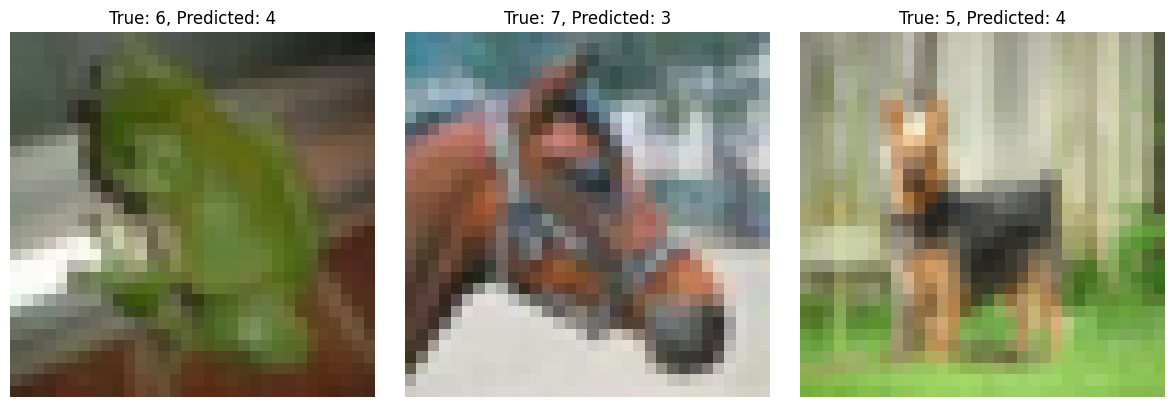

In [86]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(testset.targets)
# ----------- <Your code> ---------------
# Find misclassified images
targets = [int(t) for t in targets]
predictions = [int(p[0]) for p in predictions]
misclassified_indices = [i for i, (x, y) in enumerate(zip(predictions, targets)) if x != y]

# Plot the first `total_images` misclassified images
plt.figure(figsize=(12, 4))
for i in range(total_images):
    if i < len(misclassified_indices):
        index = misclassified_indices[i]
        misclassified_image = testset.data[index]
        true_label = testset.targets[index]
        predicted_label = predictions[index]

        plt.subplot(1, total_images, i + 1)
        plt.imshow(misclassified_image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
    else:
        break

plt.tight_layout()
plt.show()
# ----------- <End Your code> ---------------

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [87]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 301MB/s]


### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [89]:
# Create your dataloader here
# ----------- <Your code> ---------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define trainloader and testloader
test_loader = torch.utils.data.DataLoader(testset, batch_size=9, shuffle=False, num_workers=2)
# ----------- <End Your code> ---------------

Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [91]:
# ----------- <Your code> ---------------

test(resnet18.cpu(), criterion, test_loader, epoch)
# ----------- <End Your code> ---------------

Test result on epoch 4: total sample: 10000, Avg loss: 0.984, Acc: 0.040%


{'loss': 0.9843928709030151,
 'accuracy': 0.0004,
 'prediction': tensor([[118],
         [403],
         [525],
         ...,
         [275],
         [946],
         [847]])}

### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data.

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
# Directly train the whole model.
start = time.time()
#----------- <Your code> ---------------

# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

In [ ]:
# Load another resnet18 instance, only unfreeze the outer layers.
# ----------- <Your code> ---------------

# ----------- <End Your code> ---------------

In [ ]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------

# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')